# Use Snowpark_OpenAI Notebook template

In [177]:
!pip install imblearn

  Using cached https://files.pythonhosted.org/packages/81/a7/4179e6ebfd654bd0eac0b9c06125b8b4c96a9d0a8ff9e9507eb2a26d2d7e/imblearn-0.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/6e/1b/66764ecf370e797759be06fb38c11640ea1f9456ae10f8640a33cfa726ea/imbalanced_learn-0.12.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/10/40/d551139c85db202f1f384ba8bcf96aca2f329440a844f924c8a0040b6d02/joblib-1.3.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/54/30/c2a907b9443cf42b90c17ad10c1e8fa801975f01cb9764f3f8eb8aea638b/numpy-1.26.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/1e/84/ccd9b08653022b7785b6e3ee070ffb2825841e0dc119be22f0840b2b35cb/threadpoolctl-3.4.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/c6/ba/a778e6c0020d728c119b0379805a357135fe8c9bc87fdb7e0750ca11319f/scipy-1.13.0-cp39-cp39-manylinux_2_17_x86_64.manylinux20

In [178]:
!!pip install "snowflake-connector-python[pandas]"

['Collecting snowflake-connector-python[pandas]',
 '  Using cached https://files.pythonhosted.org/packages/f8/c7/03d2ca5e460acb3a31d70ee17584fbc6fe828a52c9f83bbb20a392b8988b/snowflake_connector_python-3.7.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl',
 'Collecting idna<4,>=2.5',
 '  Using cached https://files.pythonhosted.org/packages/c2/e7/a82b05cf63a603df6e68d59ae6a68bf5064484a0718ea5033660af4b54a9/idna-3.6-py3-none-any.whl',
 'Collecting pytz',
 '  Using cached https://files.pythonhosted.org/packages/9c/3d/a121f284241f08268b21359bd425f7d4825cffc5ac5cd0e1b3d82ffd2b10/pytz-2024.1-py2.py3-none-any.whl',
 'Collecting tomlkit',
 '  Using cached https://files.pythonhosted.org/packages/07/fa/c96545d741f2fd47f565e4e06bfef0962add790cb9c2289d900102b55eca/tomlkit-0.12.4-py3-none-any.whl',
 'Collecting certifi>=2017.4.17',
 '  Using cached https://files.pythonhosted.org/packages/ba/06/a07f096c664aeb9f01624f858c3add0a4e913d6c96257acb4fce61e7de14/certifi-2024.2.2-py3-none-any.whl',


In [179]:
!pip install -q matplotlib seaborn xgboost

ERROR: snowflake-ml-python 1.0.10 has requirement packaging<24,>=20.9, but you'll have packaging 24.0 which is incompatible.
ERROR: snowflake-ml-python 1.0.10 has requirement pandas<2,>=1.0.0, but you'll have pandas 2.2.1 which is incompatible.
ERROR: snowflake-ml-python 1.0.10 has requirement scikit-learn<1.4,>=1.2.1, but you'll have scikit-learn 1.4.1.post1 which is incompatible.
ERROR: snowflake-ml-python 1.0.10 has requirement xgboost<2,>=1.7.3, but you'll have xgboost 2.0.3 which is incompatible.
ERROR: jupyterlab 3.2.4 has requirement jupyter-server~=1.4, but you'll have jupyter-server 2.0.0a1 which is incompatible.
ERROR: jupyterlab-server 2.25.3 has requirement jsonschema>=4.18.0, but you'll have jsonschema 3.2.0 which is incompatible.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import pandas as pd # package for high-performance, easy-to-use data structures and data analysis
import numpy as np # fundamental package for scientific computing with Python
import matplotlib
import matplotlib.pyplot as plt # for plotting

import seaborn as sns # for making plots with seaborn
color = sns.color_palette()

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

import datetime

# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Read Customer and Payment data from Snowflake respective tables

In [2]:
#Import all snowflake connection details from template variables.

db_user = os.getenv('sf_user')
db_password =  'Password@2023' #os.getenv('sf_password')
db_account = os.getenv('sf_account')
db_database =  os.getenv('sf_db')
db_role = os.getenv('sf_role')
db_warehouse = 'FOSFOR_FDC'
db_schema = 'PUBLIC'

In [3]:
from snowflake.snowpark.session import Session
connection_params = {
    'user': db_user,
    'password': db_password,
    'account': db_account,
    'warehouse': db_warehouse,
    'database': db_database,
    'schema': db_schema,
    'role': db_role
}
session = Session.builder.configs(connection_params).create()

In [4]:
session.sql('use warehouse FOSFOR_FDC;').collect()
session.sql('use database FDC_DATA_MANISH;').collect()
session.sql('use schema FDC_DATA_MANISH.PUBLIC;').collect()

cc_customer = session.table('FDC_DATA_MANISH.PUBLIC.CC_CUSTOMER_DATA').to_pandas()
cc_payment = session.table('FDC_DATA_MANISH.PUBLIC.CC_PAYMENT_DATA').to_pandas()

# Reverse Data Engineering to get Raw data

In [5]:
cc_customer['FEA_2'] = cc_customer['FEA_2'].replace([0],np.nan)

In [6]:
cc_payment['PROD_LIMIT'] = cc_payment['PROD_LIMIT'].replace([0],np.nan)
cc_payment['HIGHEST_BALANCE'] = cc_payment['HIGHEST_BALANCE'].replace([0],np.nan)

cc_payment['UPDATE_DATE'] = cc_payment['UPDATE_DATE'].replace(['31/12/9999'],np.nan)
cc_payment['REPORT_DATE'] = cc_payment['REPORT_DATE'].replace(['31/12/9999'],np.nan)

# Check Missing Value/data

In [7]:
# checking missing data
def get_missing_data(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    percent = round(percent,2)
    missing_df  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print( missing_df.head(20))
    return None

In [8]:
get_missing_data(cc_customer)

        Total  Percent
FEA_2     149    13.24
LABEL       0     0.00
ID          0     0.00
FEA_1       0     0.00
FEA_3       0     0.00
FEA_4       0     0.00
FEA_5       0     0.00
FEA_6       0     0.00
FEA_7       0     0.00
FEA_8       0     0.00
FEA_9       0     0.00
FEA_10      0     0.00
FEA_11      0     0.00


In [9]:
get_missing_data(cc_payment)

                 Total  Percent
PROD_LIMIT        6118    74.16
REPORT_DATE       1114    13.50
HIGHEST_BALANCE    409     4.96
UPDATE_DATE         26     0.32
OVD_T3               0     0.00
OVD_T2               0     0.00
OVD_T1               0     0.00
ID                   0     0.00
PROD_CODE            0     0.00
PAY_NORMAL           0     0.00
OVD_SUM              0     0.00
NEW_BALANCE          0     0.00


In [10]:
def data_profile(df):
    stats = []
    for col in df.columns:
        stats.append((col, df[col].nunique(), df[col].isnull().sum() * 100 / df.shape[0], df[col].value_counts(normalize=True, dropna=False).values[0] * 100, df[col].dtype))

    stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
    stats_df.sort_values('Percentage of missing values', ascending=True)
    return stats_df

In [11]:
data_profile(cc_customer)

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
0,LABEL,2,0.000000,80.000000,float64
1,ID,1125,0.000000,0.088889,float64
2,FEA_1,6,0.000000,42.311111,float64
3,FEA_2,158,13.244444,13.244444,float64
4,FEA_3,3,0.000000,60.800000,float64
5,FEA_4,229,0.000000,3.022222,float64
6,FEA_5,2,0.000000,92.888889,float64
7,FEA_6,10,0.000000,41.333333,float64
8,FEA_7,10,0.000000,61.244444,float64
9,FEA_8,52,0.000000,8.711111,float64


In [12]:
data_profile(cc_payment)

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
0,ID,1125,0.000000,0.666667,int32
1,OVD_T1,21,0.000000,90.606061,int8
2,OVD_T2,16,0.000000,95.587879,int8
3,OVD_T3,33,0.000000,96.763636,int8
4,OVD_SUM,393,0.000000,88.848485,int16
5,PAY_NORMAL,37,0.000000,11.030303,int8
6,PROD_CODE,21,0.000000,54.824242,int8
7,PROD_LIMIT,321,74.157576,74.157576,float64
8,UPDATE_DATE,3041,0.315152,0.315152,object
9,NEW_BALANCE,3939,0.000000,46.836364,float64


In [13]:
cc_customer['FEA_2'] = cc_customer['FEA_2'].replace([np.nan],cc_customer['FEA_2'].mean())

In [14]:
cc_payment['HIGHEST_BALANCE'] = cc_payment['HIGHEST_BALANCE'].replace([np.nan],0)

In [15]:
cc_customer.columns

Index(['LABEL', 'ID', 'FEA_1', 'FEA_2', 'FEA_3', 'FEA_4', 'FEA_5', 'FEA_6',
       'FEA_7', 'FEA_8', 'FEA_9', 'FEA_10', 'FEA_11'],
      dtype='object')

In [16]:
Total_features=['FEA_1', 'FEA_2', 'FEA_3', 'FEA_4', 'FEA_5', 'FEA_6',
       'FEA_7', 'FEA_8', 'FEA_9', 'FEA_10', 'FEA_11']

In [17]:
cat_features = ['FEA_3','FEA_5','FEA_6','FEA_9']
num_features = ['FEA_1','FEA_2','FEA_4','FEA_7','FEA_8','FEA_10','FEA_11']

In [18]:
def standerdisation(df,num_cols):
# copy of datasets
    df_stand = df.copy()

    # apply standardization on numerical features
    for i in num_cols:

        # fit on training data column
        scale = StandardScaler().fit(df_stand[[i]])

        # transform the training data column
        df_stand[i] = scale.transform(df_stand[[i]])
        
    return df_stand

In [19]:
cc_customer_std =  standerdisation(cc_customer,num_features)

In [20]:
feat_cols=[cols for cols  in cc_customer_std.columns if cols not in ['LABEL','ID']]

# Preparing data for model

In [21]:
X_train, X_test, y_train, y_test=train_test_split(cc_customer_std[feat_cols],cc_customer_std[['LABEL']],test_size=0.15)

In [22]:
X_train.head()

,FEA_1,FEA_2,FEA_3,FEA_4,FEA_5,FEA_6,FEA_7,FEA_8,FEA_9,FEA_10,FEA_11
802,1.097352,-1.263992,3.0,-0.552944,2.0,11.0,-1.964028,1.101281,5.0,-0.087361,0.287234
567,-1.072281,0.416866,3.0,-0.971468,2.0,8.0,0.056269,0.767492,4.0,-0.607523,0.577444
574,-1.072281,-1.357373,3.0,-0.824419,2.0,8.0,0.056269,-0.901452,5.0,-0.607516,0.462693
411,1.097352,-0.952722,3.0,-0.620813,2.0,11.0,0.056269,-1.819371,3.0,1.872046,0.706044
70,1.097352,0.759263,1.0,-0.021306,2.0,11.0,0.056269,-0.400769,3.0,-0.685954,0.685220


In [23]:
y_train.head()

,LABEL
802,0.0
567,1.0
574,1.0
411,0.0
70,0.0


In [24]:
X_train.reset_index(inplace=True)
X_test.reset_index(inplace=True)
y_train.reset_index(inplace=True)
y_test.reset_index(inplace=True)

X_train.drop(columns=['index'],axis=1,inplace=True)
X_test.drop(columns=['index'],axis=1,inplace=True)
y_train.drop(columns=['index'],axis=1,inplace=True)
y_test.drop(columns=['index'],axis=1,inplace=True)

print('Shape of Train features :-',X_train.shape)
print('Shape of Test features  :-',X_test.shape)

print('Shape of Train Target   :-',y_train.shape)
print('Shape of Test Target    :-',y_test.shape)
y_train = y_train['LABEL'].copy()
y_test = y_test['LABEL'].copy()

Shape of Train features :- (956, 11)
Shape of Test features  :- (169, 11)
Shape of Train Target   :- (956, 1)
Shape of Test Target    :- (169, 1)


# Random Forest Classifier

In [31]:
forest_model = RandomForestClassifier(random_state=1)
forest_model.fit(X_train, y_train)
y_pred =forest_model.predict(X_test)

In [32]:
accuracy_score(y_test, y_pred.round())

0.7692307692307693

In [34]:
print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

         0.0       0.78      0.98      0.87       132
         1.0       0.00      0.00      0.00        37

    accuracy                           0.77       169
   macro avg       0.39      0.49      0.43       169
weighted avg       0.61      0.77      0.68       169



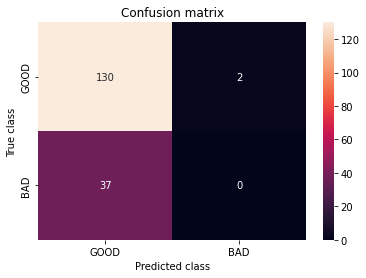

In [26]:
n_errors = (y_pred != y_test).sum()
LABELS = ['GOOD', 'BAD']
conf_matrix = confusion_matrix(y_test, y_pred.round())
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# XGBoost

In [35]:
xgb_model = XGBClassifier(random_state=1)
xgb_model.fit(X_train, y_train)
y_pred =xgb_model.predict(X_test)

In [36]:
accuracy_score(y_test, y_pred.round())

0.7396449704142012

In [37]:
print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

         0.0       0.78      0.92      0.85       132
         1.0       0.23      0.08      0.12        37

    accuracy                           0.74       169
   macro avg       0.51      0.50      0.48       169
weighted avg       0.66      0.74      0.69       169



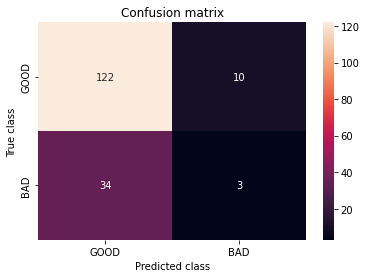

In [28]:
n_errors = (y_pred != y_test).sum()
LABELS = ['GOOD', 'BAD']
conf_matrix = confusion_matrix(y_test, y_pred.round())
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [38]:
cc_customer_std['LABEL'].value_counts()

LABEL
0.0    900
1.0    225
Name: count, dtype: int64

In [39]:
225.0/(900+225)

0.2

# Oversample Minority class using IMBLEARN

In [40]:
x_sample, y_sample = cc_customer_std[feat_cols],cc_customer_std[['LABEL']]

In [43]:
os =  RandomOverSampler(random_state=42)
X_train_res, y_train_res = os.fit_resample(x_sample, y_sample)
print(" New 'x' has",X_train_res.shape,"        New 'Y' has",y_train_res.shape)

 New 'x' has (1800, 11)         New 'Y' has (1800, 1)


In [44]:
X_train_res.head()

,FEA_1,FEA_2,FEA_3,FEA_4,FEA_5,FEA_6,FEA_7,FEA_8,FEA_9,FEA_10,FEA_11
0,-0.349070,-0.797087,3.0,-0.496387,2.0,15.0,0.056269,0.684045,5.0,-0.087361,0.976754
1,-1.072281,2.720263,3.0,-0.315404,2.0,8.0,0.056269,1.017833,4.0,-0.087361,1.233600
2,-1.072281,-0.703706,3.0,0.182301,2.0,8.0,0.056269,-0.901452,5.0,-0.607523,-1.190396
3,1.097352,-1.326246,3.0,-0.507699,2.0,11.0,-0.953879,-0.901452,5.0,-0.614069,-1.190396
4,-0.349070,0.000000,2.0,-0.801797,2.0,15.0,0.056269,0.600597,4.0,1.871935,0.302052


In [45]:
y_train_res.head()

,LABEL
0,1.0
1,0.0
2,0.0
3,0.0
4,0.0


In [46]:
#np.random.seed(123)
newX_train, newX_test, newy_train, newy_test = train_test_split(X_train_res, y_train_res, train_size = 0.70, test_size = 0.30, random_state = 1)

In [47]:
newX_train.head()

,FEA_1,FEA_2,FEA_3,FEA_4,FEA_5,FEA_6,FEA_7,FEA_8,FEA_9,FEA_10,FEA_11
1145,-1.072281,0.000000,2.0,-0.304092,2.0,8.0,-1.964028,1.017833,4.0,-0.607523,-1.190396
927,-1.072281,-2.166675,3.0,-0.733928,2.0,8.0,0.056269,-0.150427,3.0,-0.607523,0.884114
1189,-1.072281,-2.011040,3.0,-0.236224,2.0,8.0,0.056269,0.099914,3.0,-0.686124,3.666479
1065,-0.349070,1.039406,3.0,-0.213601,2.0,15.0,1.403133,-1.402135,5.0,-0.607523,0.577444
671,-0.349070,-1.419627,3.0,-0.236224,2.0,15.0,0.056269,0.767492,5.0,1.872033,1.093451


In [48]:
newy_train.head()

,LABEL
1145,1.0
927,0.0
1189,1.0
1065,0.0
671,0.0


In [49]:
newX_train.reset_index(inplace=True)
newX_test.reset_index(inplace=True)
newy_train.reset_index(inplace=True)
newy_test.reset_index(inplace=True)

newX_train.drop(columns=['index'],axis=1,inplace=True)
newX_test.drop(columns=['index'],axis=1,inplace=True)
newy_train.drop(columns=['index'],axis=1,inplace=True)
newy_test.drop(columns=['index'],axis=1,inplace=True)

print('Shape of Train features :-',newX_train.shape)
print('Shape of Test features  :-',newX_test.shape)

print('Shape of Train Target   :-',newy_train.shape)
print('Shape of Test Target    :-',newy_test.shape)
y_train = newy_train['LABEL'].copy()
y_test = newy_test['LABEL'].copy()

Shape of Train features :- (1260, 11)
Shape of Test features  :- (540, 11)
Shape of Train Target   :- (1260, 1)
Shape of Test Target    :- (540, 1)


# Random Forest on Oversampled Data

In [50]:
forest_model = RandomForestClassifier(random_state=1)
forest_model.fit(newX_train, newy_train)
newy_pred =forest_model.predict(newX_test)

/tmp/pip_packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [51]:
print(accuracy_score(newy_test, newy_pred.round()))

0.9055555555555556


In [52]:
print(classification_report(newy_test, newy_pred.round()))

              precision    recall  f1-score   support

         0.0       0.95      0.86      0.90       271
         1.0       0.87      0.95      0.91       269

    accuracy                           0.91       540
   macro avg       0.91      0.91      0.91       540
weighted avg       0.91      0.91      0.91       540



In [67]:
pd.Series(newy_test['LABEL'])

0      1.0
1      0.0
2      1.0
3      1.0
4      0.0
      ... 
535    1.0
536    1.0
537    0.0
538    0.0
539    1.0
Name: LABEL, Length: 540, dtype: float64

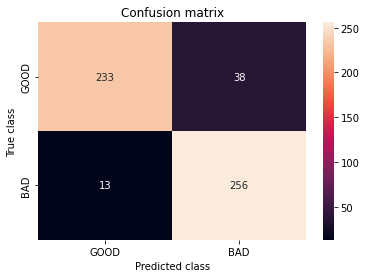

In [72]:
n_errors = (newy_pred != pd.Series(newy_test['LABEL'])).sum()
LABELS = ['GOOD', 'BAD']
conf_matrix = confusion_matrix(newy_test, newy_pred.round())
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# XGBoost on Oversampled Data

In [73]:
xgb_model = XGBClassifier(random_state=1)
xgb_model.fit(newX_train, newy_train)
newy_pred =xgb_model.predict(newX_test)

In [74]:
print (accuracy_score(newy_test, newy_pred.round()))

0.8888888888888888


In [75]:
print (classification_report(newy_test, newy_pred.round()))

              precision    recall  f1-score   support

         0.0       0.93      0.84      0.88       271
         1.0       0.85      0.94      0.89       269

    accuracy                           0.89       540
   macro avg       0.89      0.89      0.89       540
weighted avg       0.89      0.89      0.89       540



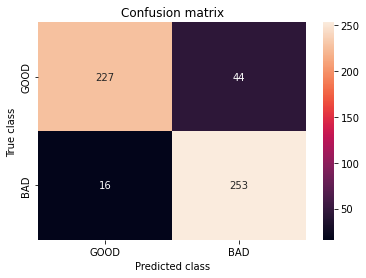

In [76]:
n_errors = (newy_pred != pd.Series(newy_test['LABEL'])).sum()
LABELS = ['GOOD', 'BAD']
conf_matrix = confusion_matrix(newy_test, newy_pred.round())
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Hyperparameters tunning of Random Forest Model

In [106]:
n_estimators = [5,20,50,100,200] # number of trees in the random forest
max_depth = [int(x) for x in np.linspace(5, 20, num = 5)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10, 50, 100] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4,5,10] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
'bootstrap': bootstrap}

In [107]:
rf = RandomForestClassifier()

In [108]:
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)

In [109]:
rf_random

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 8, 12, 16, 20],
                                        'min_samples_leaf': [1, 3, 4, 5, 10],
                                        'min_samples_split': [2, 6, 10, 50,
                                                              100],
                                        'n_estimators': [5, 20, 50, 100, 200]},
                   random_state=35, verbose=2)

In [110]:
type(newX_train),type(newy_train)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

In [111]:
rf_random.fit(newX_train,y=newy_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/tmp/pip_packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 8, 12, 16, 20],
                                        'min_samples_leaf': [1, 3, 4, 5, 10],
                                        'min_samples_split': [2, 6, 10, 50,
                                                              100],
                                        'n_estimators': [5, 20, 50, 100, 200]},
                   random_state=35, verbose=2)

In [ ]:
print ('Random grid: ', random_grid, '\n')
# print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')

In [112]:
#Use the best parameter
randmf = RandomForestClassifier(n_estimators = 50, min_samples_split = 2, min_samples_leaf= 1, max_depth= 16, bootstrap=False) 
randmf.fit( newX_train, newy_train) 

/tmp/pip_packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(bootstrap=False, max_depth=16, n_estimators=50)

In [105]:
print (accuracy_score(newy_test, newy_pred_rf.round()))

NameError: name 'newy_pred_rf' is not defined

In [89]:
print (classification_report(newy_test, newy_pred.round()))

              precision    recall  f1-score   support

         0.0       0.96      0.87      0.91       271
         1.0       0.88      0.96      0.92       269

    accuracy                           0.91       540
   macro avg       0.92      0.91      0.91       540
weighted avg       0.92      0.91      0.91       540



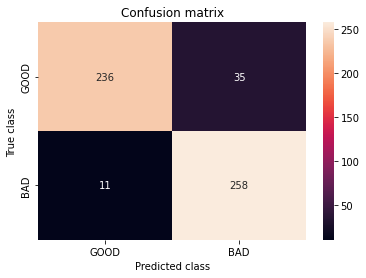

In [87]:
newy_pred_rf =randmf.predict(newX_test)
n_errors = (newy_pred_rf != pd.Series(newy_test['LABEL'])).sum()
LABELS = ['GOOD', 'BAD']
conf_matrix = confusion_matrix(newy_test, newy_pred_rf.round())
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Hyperparameter tunning of XGBoost model

In [90]:
params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01,0.05,0.1],
    'booster': ['gbtree', 'gblinear'],
    'gamma': [0, 0.5, 1],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 5],
    'base_score': [0.2, 0.5, 0.9]
}

gs2 = RandomizedSearchCV(XGBClassifier(n_jobs=-1), params, n_jobs=-1, cv=KFold(n_splits=3), scoring='roc_auc')
gs2.fit(newX_train, newy_train)

print('Best score:', gs2.best_score_)
print('Best score:', gs2.best_params_)

Best score: 0.8455992689749516
Best score: {'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 500, 'learning_rate': 0.05, 'gamma': 0.5, 'booster': 'gbtree', 'base_score': 0.9}


In [92]:
gs3 = XGBClassifier(reg_lambda=1, reg_alpha=1, n_estimators=500, learning_rate=0.05, gamma=0.5, 
                    booster='gbtree', base_score=0.9)
gs3.fit(newX_train, newy_train)

XGBClassifier(base_score=0.9, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [95]:
print (accuracy_score(newy_test, newy_pred.round()))

0.7907407407407407


In [96]:
print (classification_report(newy_test, newy_pred.round()))

              precision    recall  f1-score   support

         0.0       0.82      0.74      0.78       271
         1.0       0.76      0.84      0.80       269

    accuracy                           0.79       540
   macro avg       0.79      0.79      0.79       540
weighted avg       0.79      0.79      0.79       540



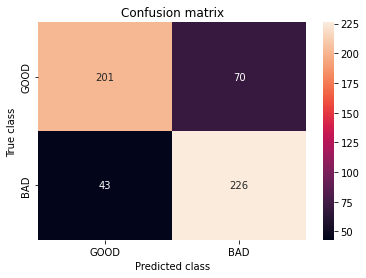

In [94]:
newy_pred =gs3.predict(newX_test)
n_errors = (newy_pred != pd.Series(newy_test['LABEL'])).sum()
LABELS = ['GOOD', 'BAD']
conf_matrix = confusion_matrix(newy_test, newy_pred.round())
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()